/home/fireholder/.local/lib/python3.8/site-packages/kwant/_plotter.py:70: RuntimeWarning: plotly is not available, if other engines are unavailable, only iterator-providing functions will work
  warnings.warn("plotly is not available, if other engines are unavailable,"


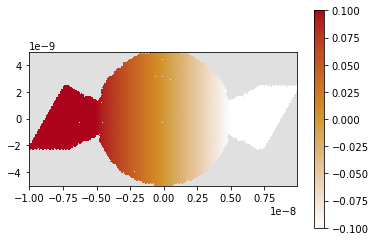

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import kwant
import scipy.sparse.linalg as sla
import scipy.linalg as la
from tqdm import tqdm
from math import *
import scipy.integrate as integrate
import tinyarray

k_b = 1.380649e-23 #m^2 kg/s^2/K
q_e = 1.6e-19
h = 6.626176e-34 # in meter
hbar = 1.054571e-34 # in meters


sigma_0 = tinyarray.array([[1, 0], [0, 1]])
sigma_x = tinyarray.array([[0, 1], [1, 0]])
sigma_y = tinyarray.array([[0, -1j], [1j, 0]])
sigma_z = tinyarray.array([[1, 0], [0, -1]])

# h=4.1357e-15 # ev * s
# hbar = 6.5821e-16 # ev * s
# q_e = 1

ev_to_j = 1.6e-19



def make_system(r, t, tp, left_pot, right_pot, leads):
    side = -1e-10
    if r > 1:
        r *= 1e-10
    a = 2.46e-10 # angstroms
    # Define the graphene lattice
    sin_30, cos_30 = (1 / 2, sqrt(3) / 2)
    lat = kwant.lattice.general([(a, 0), (a*sin_30, a*cos_30)],
                                 [(0, 0), (0, a / sqrt(3))], norbs=2)
    electrode_bound = 1.5*r
    electrode_slope = 1/2

    b,c = lat.sublattices

    # hopping along the A field direction (perpendicular to B field)
    def hopy(site1, site2, B):
        x = site1.pos[0]
        return sigma_0 * t * np.exp(1j * B * x * q_e/hbar * a / sqrt(3))
        # try e / (hbar c)

    def hop_right(site1, site2, B):
        x_0 = site1.pos[0]
        const = -B*x_0*a/sqrt(12)-B*a**2/(4*sqrt(12)) # computed with pierels integral
        return sigma_0 * t * np.exp(1j * const * q_e/hbar)

    def hop_left(site1, site2, B):
        x_0 = site1.pos[0]
        const = -B*x_0*a/sqrt(12)+B*a**2/(4*sqrt(12)) # computed with pierels integral
        return sigma_0 * t * np.exp(1j * const * q_e/hbar)


    def circle(pos):
        x, y = pos
        return x**2 + y**2 < r**2

    # side = -1 for left, 1 for right
    def electrode_shape(pos):
        x,y = pos
        if x**2 + y**2 < r**2:
            return False
        return abs(y) + r/ 4 < side/abs(side) * x * electrode_slope and abs(x) < electrode_bound

    def make_lead(pot):
        # Start with an empty lead with a single square lattice
        lead_lattice = kwant.lattice.honeycomb(a, norbs=2)

        sym_lead = kwant.TranslationalSymmetry(lead_lattice.vec((-1,0)))
        lead = kwant.Builder(sym_lead, conservation_law=-sigma_z)

        def lead_shape(pos):
            x, y = pos
            return abs(y) + r/4 < electrode_slope * electrode_bound-2e-10

        lead[lead_lattice.shape(lead_shape, (0, 0))] = pot * sigma_0

        lead[lead_lattice.neighbors()] = t * sigma_0
        return lead

    def potential(site, E_z):
        x,y = site.pos
        m = (left_pot - right_pot)/(2*r)
        return (-m*(x-r) + right_pot) * sigma_0 + E_z * sigma_z

    syst = kwant.Builder()
    syst[lat.shape(circle, (0, 0))] = potential

    syst[lat.shape(electrode_shape, (-r,0))] = left_pot * sigma_0
    side *= -1
    syst[lat.shape(electrode_shape, (r,0))] = right_pot * sigma_0

    ## hoppings
    hoppings_up = ((0,0),b,c)
    syst[kwant.builder.HoppingKind(*hoppings_up)] = hopy

    hoppings_left = ((0, 1), b, c)
    syst[kwant.builder.HoppingKind(*hoppings_left)] = hop_left

    hoppings_right = ((-1, 1), b, c)
    syst[kwant.builder.HoppingKind(*hoppings_right)] = hop_right
    ## hop_right and left might be swapped, pretty sure they are correct though

    syst.eradicate_dangling()

    if leads:
        syst.attach_lead(make_lead(pot = left_pot * sigma_0))
        syst.attach_lead(make_lead(pot = right_pot * sigma_0).reversed())

    if tp:
        syst[lat.neighbors(2)] = tp

    return syst


def hopping_lw(site1, site2):
    return 0.04 if site1.family == site2.family else 0.1


def sort_evals(vals, vecs):
    vecs = [vecs[:,n] for n in range(len(vals))]
    print(np.shape(vecs), np.shape(vals))
    temp = sorted(zip(vals, vecs))
    vecs = list(np.array(temp)[:,1])
    return np.array(temp)[:,0], vecs

def plot_data(syst, ns,params):
    ham = syst.hamiltonian_submatrix(sparse=True, params = params)
    print("Solving N={} matrix".format(ham.shape[0]))
    evals, evecs = sla.eigsh(ham, max(ns)+1)
    evals, evecs = sort_evals(evals, evecs)
    for n in ns:
        wf = abs(evecs[n])**2
        def site_size(i):
            return 3 * wf[i] / wf.max()
        kwant.plot(syst, site_size=site_size, site_color=(0, 1, 1, 0.3),
               hop_lw=0.1, fig_size=(6,6))
    plt.plot(evals)
    plt.show()


t = -2.7 * ev_to_j
doping_level = -0.5 * ev_to_j # eV
v_sd = .2*ev_to_j # ev


left_pot = v_sd/2
right_pot = -v_sd/2

syst = make_system(r=50,t=-t, left_pot=left_pot, right_pot=right_pot, tp=None, leads = True)
syst = syst.finalized()

kwant.plotter.map(syst, lambda i: 1/2/ev_to_j*np.sum(syst.hamiltonian(i, i
                , params=dict(B=0, E_z = 0.01*ev_to_j))));

# E_zs = np.linspace(0,1*ev_to_j,5)
# frames = []
# default_B = 0
# for E_z in tqdm(E_zs):
#     params = dict(B=default_B, E_z = E_z)
#     spectrum = kwant.kpm.SpectralDensity(syst, rng=0, params=params)
#     energies, densities = spectrum()
#     frames.append((E_z, energies, densities))

In [ ]:
fig = plt.figure()
axs = plt.gca()
for B, energies, densities in frames[::]:
    axs.plot(energies/ev_to_j, densities, label="{}".format(B))

# plt.legend()
axs.set_xlabel("Energy (eV)")
axs.set_ylabel("Density of states")
plt.show()

from matplotlib import animation

fig = plt.figure(figsize=(10,8))
ax = plt.axes(xlim=axs.get_xlim(), ylim=axs.get_ylim())
line, = ax.plot([], [], lw=2)
ax.legend()
# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return line,

def animate(frame):
    B, energies, densities = frame
    ax.set_title("B-Field = {}T".format(round(B,3)))
    ax.set_xlabel("Energy (eV)")
    ax.set_ylabel("Density of states")
    line.set_data(energies/ev_to_j, densities)

    return line,

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=frames, interval=200, blit=True)

anim.save('magnetic-dos.mp4', fps=1, extra_args=['-vcodec', 'libx264'])
plt.show()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:22<00:00,  2.26it/s]


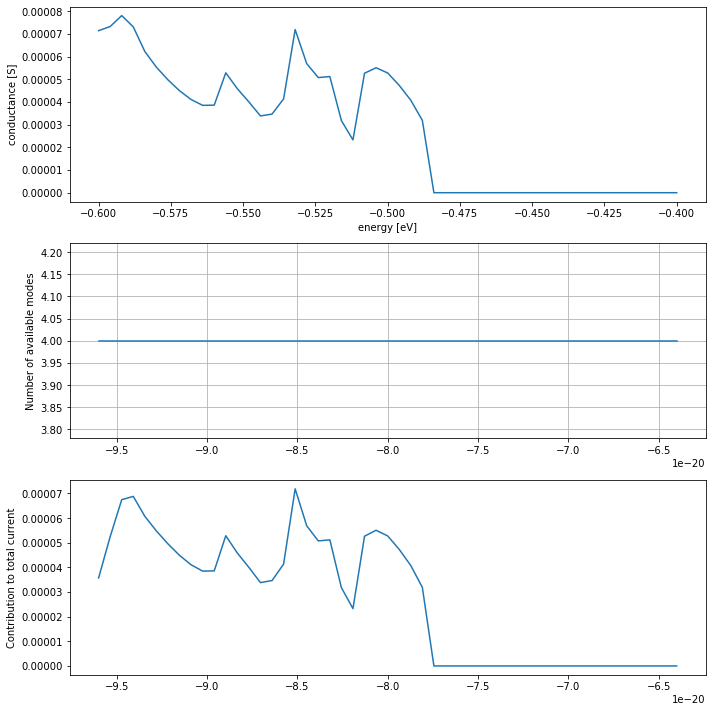

In [16]:

def fermi(eps, mu, T):
    return 1/(1+np.exp((eps-mu)/(k_b*T)))

def plot_conductance(syst, energies, mu_left, mu_right, temp, params, silent=False):
    # Compute transmission as a function of energy
    data = []
    data2 = []
    modes = []
    current_sum = 0
    dE = energies[1] - energies[0]

    for energy in tqdm(energies):
        smatrix = kwant.smatrix(syst, energy, params = params)

        modes.append(smatrix.num_propagating(0))

        # total conductance
        data.append(smatrix.transmission(1, 0)*q_e**2/h)
        # smatrix.transmission((1,0), (0,0)) # look at spin ups

        current_sum += dE * data[-1] * (fermi(energy,mu_left, temp) - fermi(energy, mu_right, temp)) / q_e

        data2.append(data[-1]*(fermi(energy, mu_left, temp) - fermi(energy, mu_right, temp)))

    if not silent:
        fig, axs = plt.subplots(3,figsize=(10,10))
        axs[0].plot(energies/ev_to_j, data)

        axs[0].set_xlabel("energy [eV]")
        axs[0].set_ylabel("conductance [S]")

        axs[1].set_ylabel("Number of available modes")
        axs[1].plot(energies, modes)
        axs[1].grid()

        axs[2].plot(energies, data2)
        axs[2].set_ylabel("Contribution to total current")

        plt.tight_layout()
        plt.savefig("graphs/conductance plot")
        plt.show()
    return current_sum, energies, data


def plot_bandstructure(flead, momenta):
    bands = kwant.physics.Bands(flead)
    energies = [bands(k)/ev_to_j for k in tqdm(momenta)]

    plt.figure(figsize=(10,6))
    plt.plot(momenta, energies,alpha=0.5)

    plt.xlabel("momentum [(lattice constant)^-1]")
    plt.ylabel("energy [ev]")
    plt.grid()
    plt.show()
    return energies

def make_IV_curve(voltages, temp):
    currents = []
    if -doping_level*2 in voltages:
        print("Remove 0 term otherwise we get 0 momentum modes")
    for v_sd in voltages:
        left_pot = v_sd/2
        right_pot = -v_sd/2
        syst = make_system(r=150,t=-t, left_pot=left_pot, right_pot=right_pot, tp=None, leads = True)

        syst = syst.finalized()

        span = left_pot - right_pot
        energies = np.linspace(doping_level-span, doping_level+span, 70)
        current, _, _ = \
            plot_conductance(syst, energies,
            doping_level+left_pot, doping_level+right_pot, temp, silent=True)
        print("Current for {}V = {}".format(v_sd, current))
        currents.append(current)
    return currents



def plot_spectrum(syst, Bfields, k):
    energies = []
    for B in tqdm(Bfields):
        # Obtain the Hamiltonian as a sparse matrix
        ham_mat = syst.hamiltonian_submatrix(params=dict(B=0, E_z=B), sparse=True)

        # we only calculate the k lowest eigenvalues
        ev = sla.eigsh(ham_mat.tocsc(), k=k, sigma=0,
                       return_eigenvectors=False)

        energies.append(ev)

    return Bfields, energies


# temp = 50
# v_sd = 0.2
# left_pot = v_sd/2*ev_to_j
# right_pot = -v_sd/2*ev_to_j
# syst = make_system(r=50,t=-t, left_pot=left_pot, right_pot=right_pot, tp=None, leads = True)
#
# syst = syst.finalized()
#
# Bs = np.linspace(0,.1*ev_to_j,300)
# Bs, energies = plot_spectrum(syst, Bs, 10)


# Compute the band structure of lead 0.
# momenta = np.linspace(-pi, pi, 500)
# eng = plot_bandstructure(syst.leads[0], momenta)

temp = 50
span = left_pot - right_pot
energies = np.linspace(doping_level-span/2, doping_level+span/2, 51)
params = dict(B=5, E_z = 0.1*ev_to_j)

current, voltages, conductances = \
    plot_conductance(syst, energies, doping_level+left_pot, doping_level+right_pot, temp,
                     params = params, silent=False)


In [13]:
current

5.119268479215981e-06

In [15]:
current

5.441712700568047e-06

IndexError: index 10 is out of bounds for axis 1 with size 10

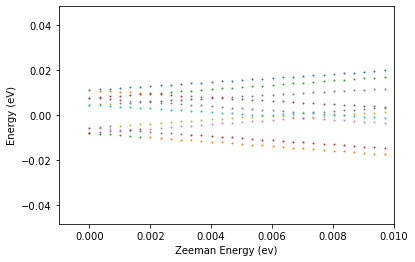

In [10]:
evs = []
for ev in energies:
    evs.append(ev[::])
# plt.xlim(0,27)
evs = np.array(evs)/ev_to_j


plt.ylabel("Energy (eV)")
plt.xlabel("Zeeman Energy (ev)")
plt.xlim(-.001,0.01)
for i in range(len(Bs)):
    plt.scatter(Bs/ev_to_j, evs[:,i],s=1)

plt.show()

In [5]:
old_data #= voltages, conductances


plt.plot(voltages, conductances)
plt.plot(old_data[0], old_data[1])
plt.xlabel("Bias (V)")
plt.ylabel("Conductances (q^2/h)")
plt.show()

NameError: name 'old_data' is not defined